# Filament Diameter Data Analysis

In [1]:
import os
import pandas as pd
import re
import numpy as np
import statsmodels.stats.multicomp as multi
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
from scikit_posthocs import posthoc_dunn
from statsmodels.graphics.factorplots import interaction_plot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc
import itertools
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
gc.collect()

0

In [3]:
# Global switch to control the use of rolling averages and segmenting
rolling_average_switch = True
segment_switch = False
rolling_avg_resolution = 10
down_sample_value = 1

In [4]:
# Define both directories and individual files
directories = {
    'PETG_01': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_01_BS',
    'PETG_05': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_05_BS',
    'PLA_04': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_04_BS'
}

file_paths = {
    'PLA_02': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_02_BS.csv',
    'PLA_03': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_03_BS.csv',
    'PLA_01': r'C:\Users\David\Documents\Eric_Work\PLA\PLA_01_BS.csv',
    'PETG_03': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_03_BS.csv',
    'PETG_04': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_04_BS.csv',
    'PETG_02': r'C:\Users\David\Documents\Eric_Work\PETG\PETG_02_BS.csv'
}

def process_data(path, start_index=0):
    df = pd.read_csv(path, skiprows=1, low_memory=False)
    numeric_columns = ['adc_1', 'adc_2', 'diameter_1', 'diameter_2', 'length']
    for col in numeric_columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df['counter'] = pd.to_numeric(df['counter'], errors='coerce')
    df.dropna(subset=numeric_columns + ['counter'], inplace=True)
    df['counter'] = (df['counter'] - df['counter'].iloc[0] + start_index).astype(int)
    df = df[(df['counter'] >= start_index) & (df['counter'] <= 300000)]
    if 'length' in df.columns and len(df['length']) > 1:
        initial_length = 1.494118
        increment = df['length'].iloc[1] - df['length'].iloc[0]
        df['length'] = initial_length + df['counter'] * increment
    return df

def process_directory(directory_path):
    csv_files = glob.glob(os.path.join(directory_path, '*.csv'))
    csv_files.sort()
    all_dataframes = []
    start_index = 0
    for file in csv_files:
        df = process_data(file, start_index=start_index)
        if not df.empty:
            start_index = df['counter'].max() + 1
        all_dataframes.append(df)
    return pd.concat(all_dataframes, ignore_index=True)

# Function to remove outliers from 'length' column
def remove_length_outliers(df):
    Q1 = df['length'].quantile(0.25)
    Q3 = df['length'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['length'] >= lower_bound) & (df['length'] <= upper_bound)]

output_directory = r'C:\Users\David\Documents\Eric_Work\Processed_CSV_Files'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Process and store dataframes from both directories and individual files
dataframes = {}
for key, directory in directories.items():
    concatenated_df = process_directory(directory)
    output_path = os.path.join(output_directory, f'{key}_processed_data.csv')
    concatenated_df.to_csv(output_path, index=False)
    print(f'Saved {key} processed data to {output_path}')
    dataframes[key] = concatenated_df  # Add directory dataframes to the dictionary

for name, path in file_paths.items():
    dataframes[name] = process_data(path)  # Add individual file dataframes to the dictionary

# Optional: Segment Switch and Outlier Removal
if 'segment_switch' in globals() and segment_switch:
    segmented_dataframes = {}
    for name, df in dataframes.items():
        sixth = len(df) // 6
        segmented_dataframes[name] = {
            'first': remove_length_outliers(df.iloc[:sixth]),
            'second': remove_length_outliers(df.iloc[sixth:2*sixth]),
            'third': remove_length_outliers(df.iloc[2*sixth:3*sixth]),
            'fourth': remove_length_outliers(df.iloc[3*sixth:4*sixth]),
            'fifth': remove_length_outliers(df.iloc[4*sixth:5*sixth]),
            'sixth': remove_length_outliers(df.iloc[5*sixth:])
        }
    dataframes = segmented_dataframes

# Print the final DataFrames to verify
for name, df in dataframes.items():
    print(f"\n{name} DataFrame:")
    if 'segment_switch' in globals() and segment_switch:
        for segment, segment_df in df.items():
            print(f"{segment} Segment:")
            print(segment_df.tail())
    else:
        print(df.tail())
    print("-" * 40)


Saved PETG_01 processed data to C:\Users\David\Documents\Eric_Work\Processed_CSV_Files\PETG_01_processed_data.csv
Saved PETG_05 processed data to C:\Users\David\Documents\Eric_Work\Processed_CSV_Files\PETG_05_processed_data.csv
Saved PLA_04 processed data to C:\Users\David\Documents\Eric_Work\Processed_CSV_Files\PLA_04_processed_data.csv

PETG_01 DataFrame:
        counter  adc_1  adc_2  diameter_1  diameter_2         length
189363   189675   2592   2637    1.741213    1.782081  283398.258822
189364   189676   2590   2641    1.743731    1.777855  283399.752940
189365   189677   2586   2638    1.748768    1.781025  283401.247058
189366   189678   2590   2636    1.743731    1.783138  283402.741175
189367   189679   2594   2637    1.738694    1.782081  283404.235293
----------------------------------------

PETG_05 DataFrame:
        counter   adc_1   adc_2  diameter_1  diameter_2         length
213512   213511  3649.0  3895.0    0.410208    0.452820  319012.047057
213513   213512  3648.0

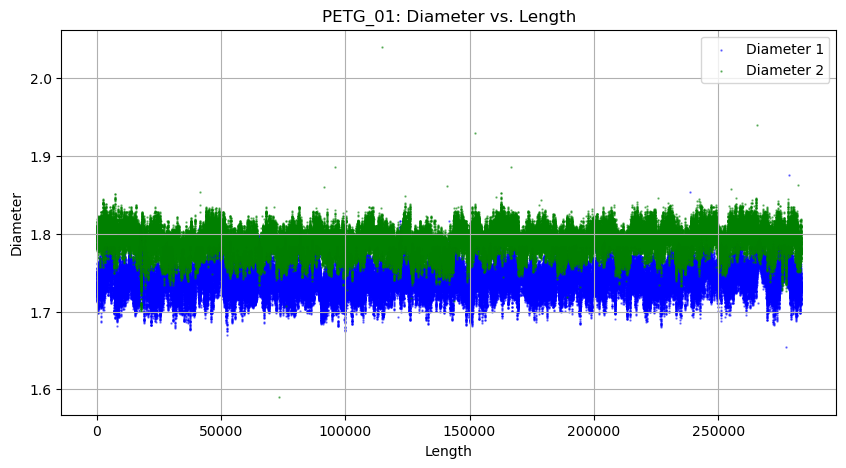

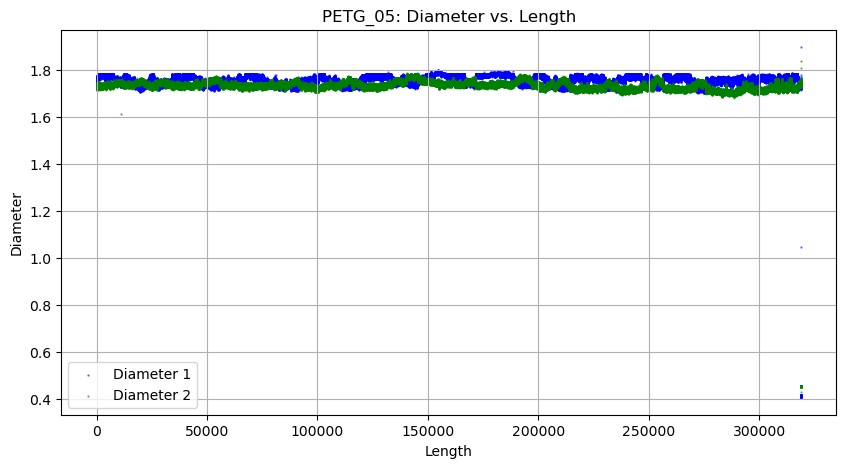

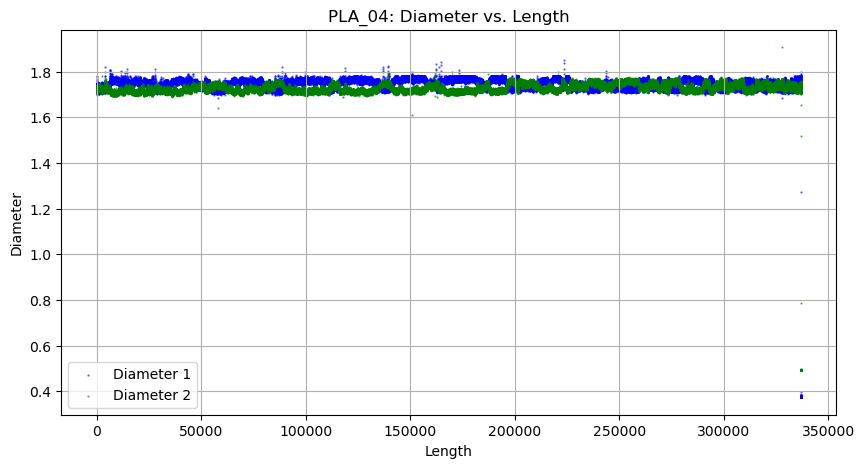

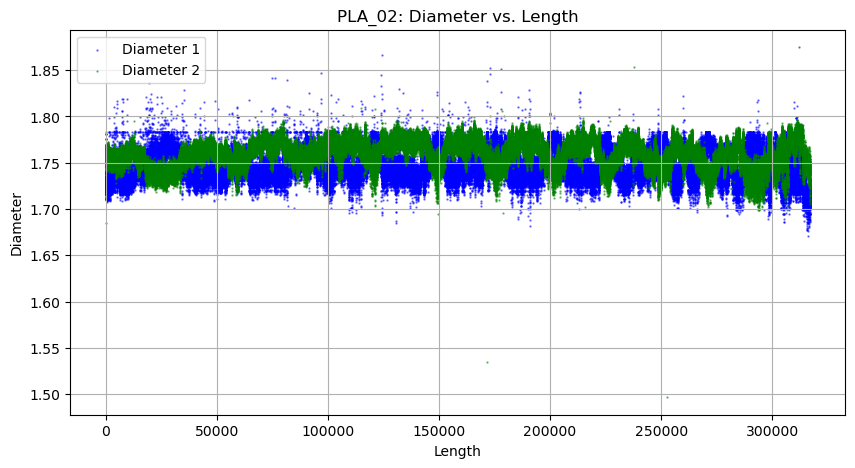

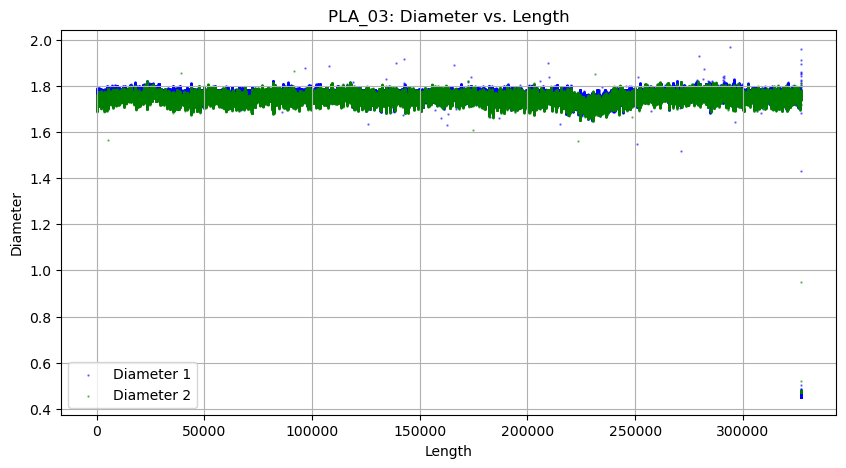

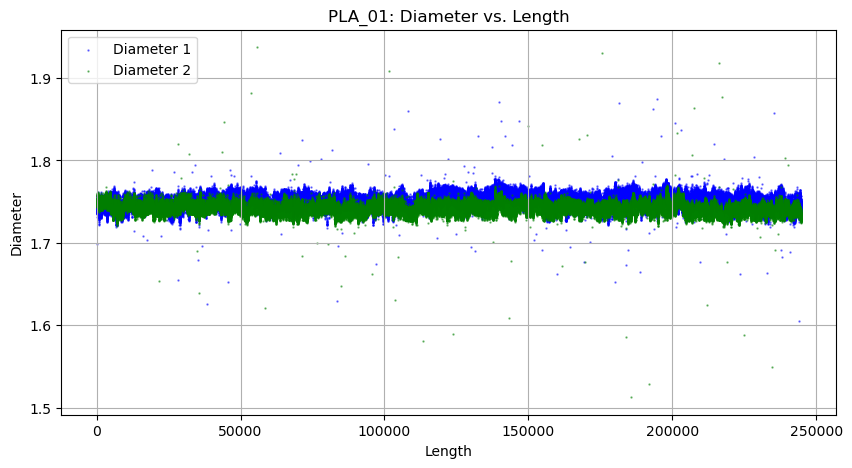

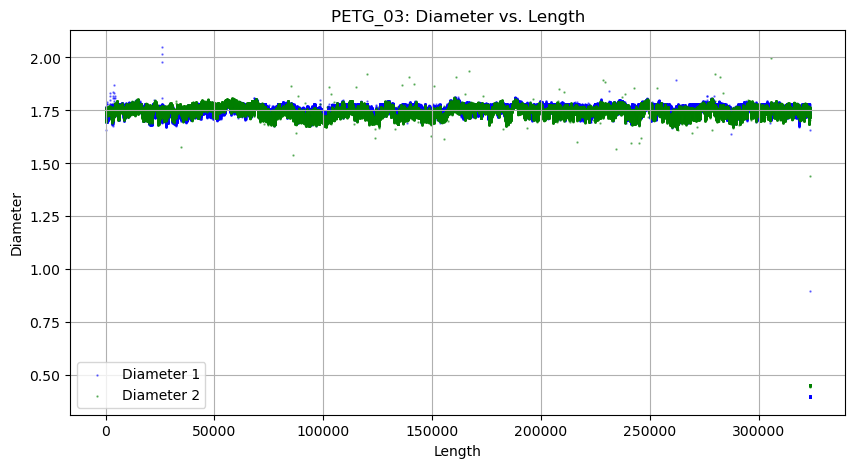

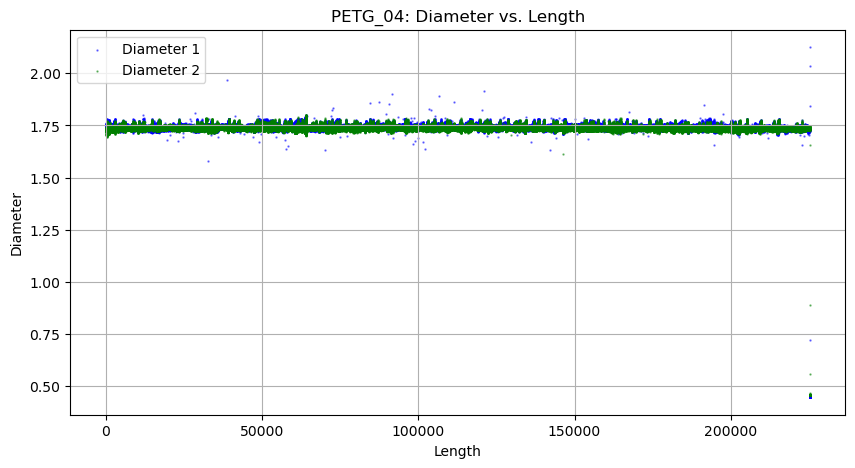

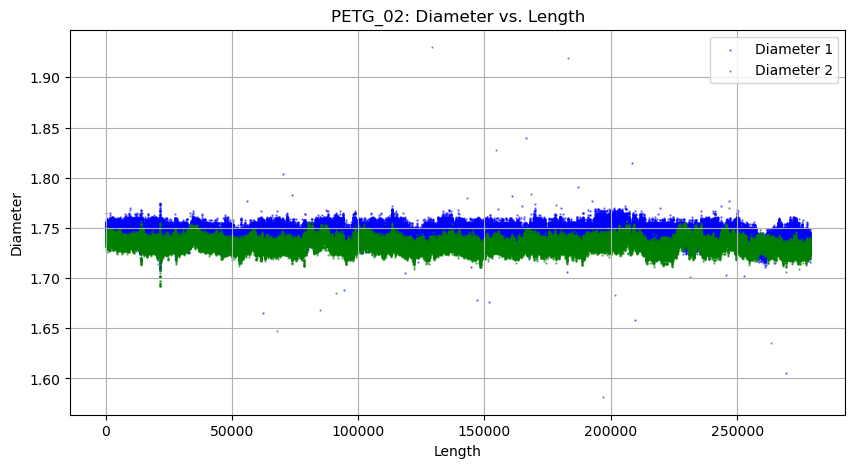

In [5]:
def plot_diameters(df, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(df['length'], df['diameter_1'], alpha=0.5, label='Diameter 1', color='blue', s=0.5)
    plt.scatter(df['length'], df['diameter_2'], alpha=0.5, label='Diameter 2', color='green', s=0.5)

    plt.title(title)
    plt.xlabel('Length')
    plt.ylabel('Diameter')
    plt.legend()
    plt.grid(True)
    plt.show()

if segment_switch:
    for name, segments in dataframes.items():
        for segment_name, segment_df in segments.items():
            plot_diameters(segment_df, f'{name} - {segment_name}: Diameter vs. Length')
else:
    for name, df in dataframes.items():
        plot_diameters(df, f'{name}: Diameter vs. Length')


Processing PETG_01
count    189328.000000
mean          1.766622
std           0.011377
min           1.712948
25%           1.758767
50%           1.766728
75%           1.774631
max           1.811865
Name: diameter_avg, dtype: float64


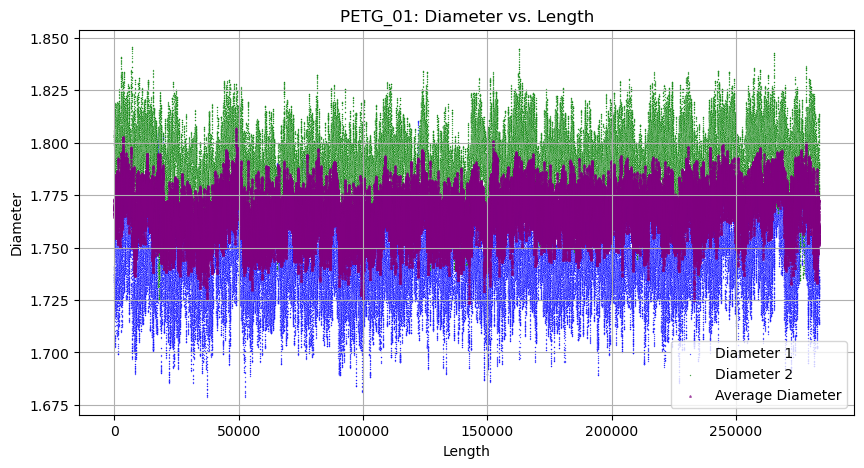

Processing PETG_05
count    213407.000000
mean          1.744946
std           0.008935
min           1.710342
25%           1.738603
50%           1.744336
75%           1.751196
max           1.774231
Name: diameter_avg, dtype: float64


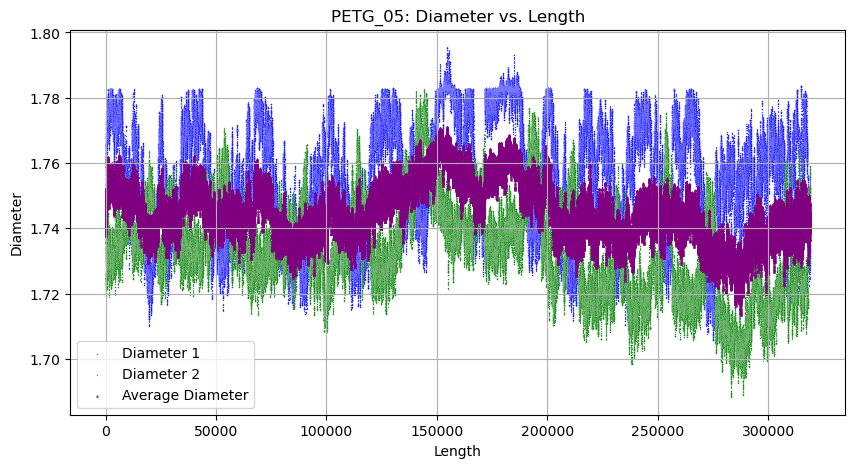

Processing PLA_04
count    225430.000000
mean          1.737769
std           0.005472
min           1.701289
25%           1.734254
50%           1.738010
75%           1.741483
max           1.789849
Name: diameter_avg, dtype: float64


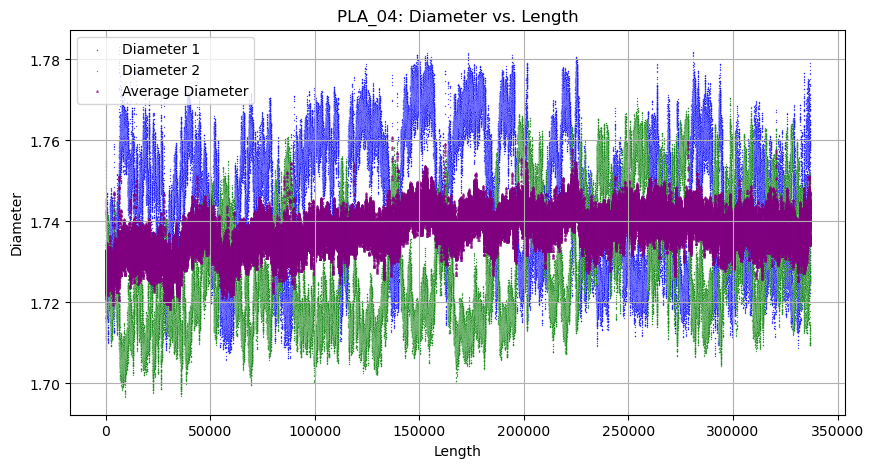

Processing PLA_02
count    212075.000000
mean          1.753202
std           0.007117
min           1.702932
25%           1.748888
50%           1.753418
75%           1.757738
max           1.799547
Name: diameter_avg, dtype: float64


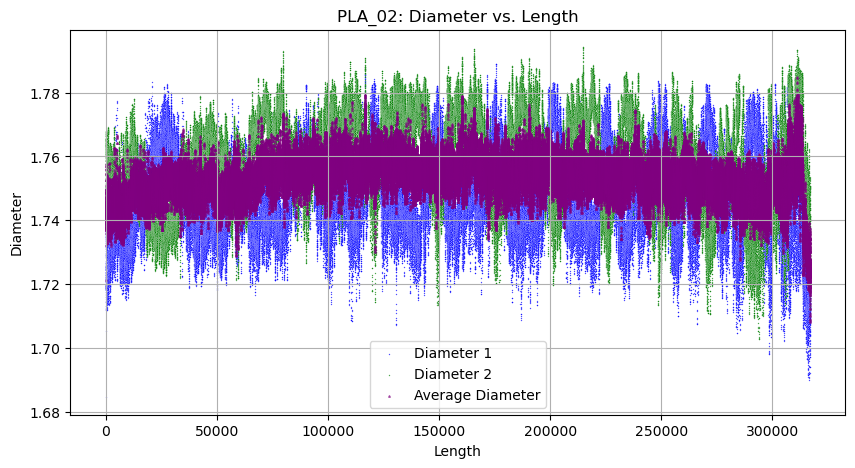

Processing PLA_03
count    218948.000000
mean          1.753957
std           0.017011
min           1.669590
25%           1.743742
50%           1.755484
75%           1.765866
max           1.818290
Name: diameter_avg, dtype: float64


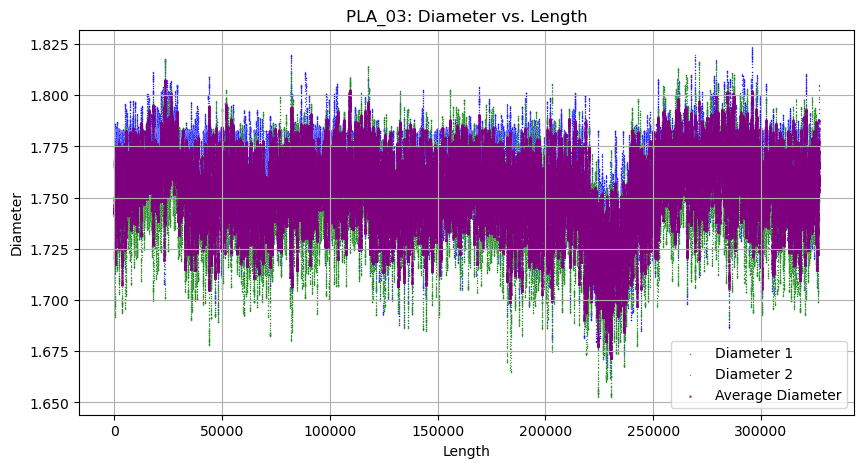

Processing PLA_01
count    163705.000000
mean          1.746588
std           0.005085
min           1.722190
25%           1.743235
50%           1.746608
75%           1.750002
max           1.770295
Name: diameter_avg, dtype: float64


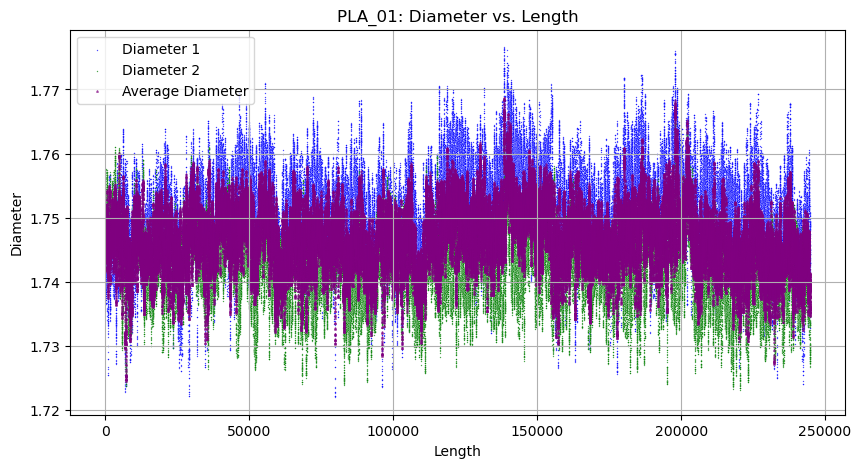

Processing PETG_03
count    215792.000000
mean          1.749574
std           0.018943
min           1.675495
25%           1.737591
50%           1.750689
75%           1.763325
max           1.820587
Name: diameter_avg, dtype: float64


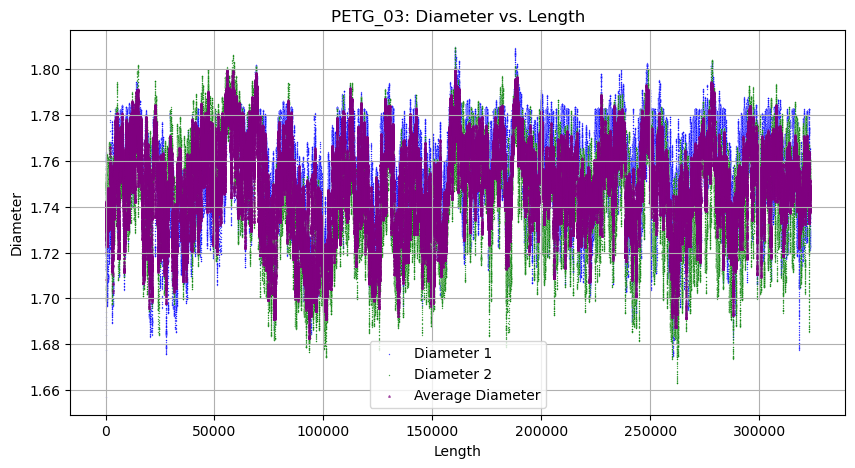

Processing PETG_04
count    149672.000000
mean          1.739399
std           0.006806
min           1.710712
25%           1.735050
50%           1.738850
75%           1.743112
max           1.772936
Name: diameter_avg, dtype: float64


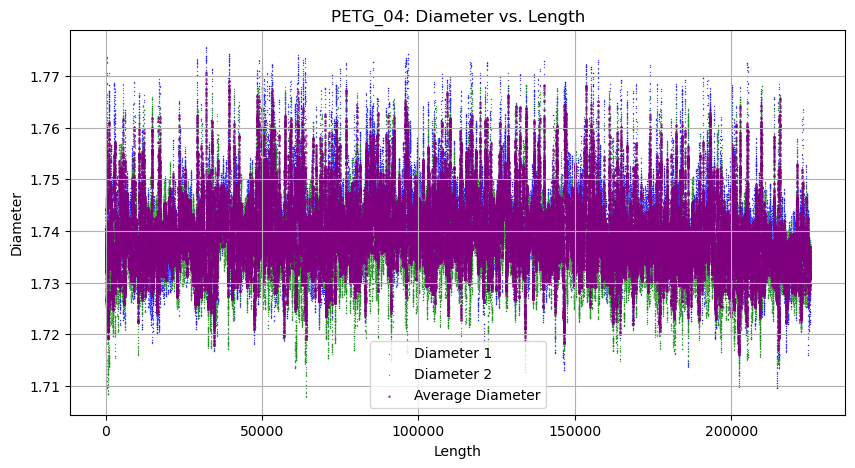

Processing PETG_02
count    187090.000000
mean          1.739235
std           0.004954
min           1.718311
25%           1.735962
50%           1.739334
75%           1.742606
max           1.759345
Name: diameter_avg, dtype: float64


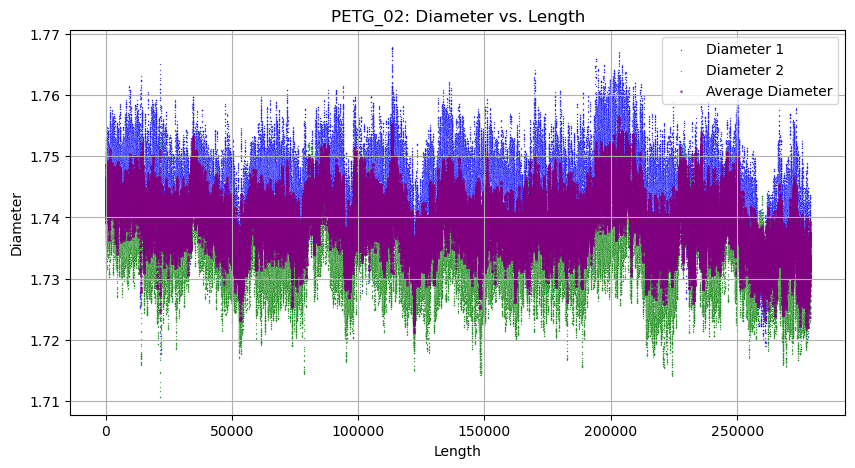

In [6]:
def remove_outliers(df, column_name):
    if column_name in df.columns:
        Q1 = df[column_name].quantile(0.25)
        Q3 = df[column_name].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        return df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)]
    return df

def apply_rolling_average_and_downsample(df, downsample_factor, rolling_avg_resolution):
    # Create a copy to avoid modifying the original dataframe unintentionally
    df_copy = df.copy()

    # Apply rolling average conditionally on column existence
    if 'length' in df_copy.columns:
        df_copy['length_ra'] = df_copy['length'].rolling(window=rolling_avg_resolution, min_periods=1).mean()
    
    if 'diameter_1' in df_copy.columns:
        df_copy['diameter_1_ra'] = df_copy['diameter_1'].rolling(window=rolling_avg_resolution, min_periods=1).mean()
    
    if 'diameter_2' in df_copy.columns:
        df_copy['diameter_2_ra'] = df_copy['diameter_2'].rolling(window=rolling_avg_resolution, min_periods=1).mean()
    
    if 'diameter_1_ra' in df_copy.columns and 'diameter_2_ra' in df_copy.columns:
        df_copy['diameter_avg_ra'] = df_copy[['diameter_1_ra', 'diameter_2_ra']].mean(axis=1)
    elif 'diameter_avg' in df_copy.columns:
        df_copy['diameter_avg_ra'] = df_copy['diameter_avg'].rolling(window=rolling_avg_resolution, min_periods=1).mean()

    # Downsample by selecting every 'downsample_factor' row
    downsampled_df = df_copy.iloc[::downsample_factor].copy()  # Ensure to copy the downsized data to reset the index and avoid future warnings
    return downsampled_df

def plot_diameters(df, title, use_rolling_average):    
    plt.figure(figsize=(10, 5))
    x = df['length_ra'] if use_rolling_average else df['length']
    y1 = df['diameter_1_ra'] if use_rolling_average else df['diameter_1']
    y2 = df['diameter_2_ra'] if use_rolling_average else df['diameter_2']
    y_avg = df['diameter_avg_ra'] if use_rolling_average else df['diameter_avg']

    sns.scatterplot(x=x, y=y1, alpha=0.7, label='Diameter 1', color='blue', s=1)
    sns.scatterplot(x=x, y=y2, alpha=0.7, label='Diameter 2', color='green', s=1)
    plt.scatter(x, y_avg, alpha=0.7, label='Average Diameter', color='purple', s=1, marker='^')

    plt.title(title)
    plt.xlabel('Length')
    plt.ylabel('Diameter')
    plt.legend()
    plt.grid(True)
    # Suppressing warnings related to creating legends with large datasets
    warnings.simplefilter("ignore", category=UserWarning)
    plt.show()

# Loop to process dataframes
for name, item in dataframes.items():
    if segment_switch and isinstance(item, dict):
        for segment_name, segment_df in item.items():
            print(f"Processing {name} - {segment_name}")
            segment_df = remove_outliers(segment_df, 'diameter_1')
            segment_df = remove_outliers(segment_df, 'diameter_2')
            segment_df['diameter_avg'] = segment_df[['diameter_1', 'diameter_2']].mean(axis=1)
            if rolling_average_switch:
                segment_df = apply_rolling_average_and_downsample(segment_df, down_sample_value, rolling_avg_resolution)
            dataframes[name][segment_name] = segment_df  # Update the segment
            print(segment_df['diameter_avg'].describe())
            plot_diameters(segment_df, f"{name} - {segment_name}: Diameter vs. Length", rolling_average_switch)
    elif isinstance(item, pd.DataFrame):
        print(f"Processing {name}")
        item = remove_outliers(item, 'diameter_1')
        item = remove_outliers(item, 'diameter_2')
        item['diameter_avg'] = item[['diameter_1', 'diameter_2']].mean(axis=1)
        if rolling_average_switch:
            item = apply_rolling_average_and_downsample(item, down_sample_value, rolling_avg_resolution)
        dataframes[name] = item  # Update the DataFrame
        print(item['diameter_avg'].describe())
        plot_diameters(item, f"{name}: Diameter vs. Length", rolling_average_switch)
    else:
        print(f"Unsupported data structure in dataframes[{name}]")

In [7]:
processed_dataframes = {}
for name, item in dataframes.items():
    if segment_switch and isinstance(item, dict):  # Check if dataframes are segmented
        for segment_name, df in item.items():
            if rolling_average_switch:
                df = segment_df = apply_rolling_average_and_downsample(df, down_sample_value, rolling_avg_resolution)
            
            std = df['diameter_avg'].std()
            n = df['diameter_avg'].count()
            df['segment'] = segment_name  # Adding segment identifier
            df['group'] = name  # Group by filament type
            processed_dataframes[f"{name}_{segment_name}"] = df
    elif isinstance(item, pd.DataFrame):  # Handle non-segmented dataframes
        if rolling_average_switch:
            item = segment_df = apply_rolling_average_and_downsample(item, down_sample_value, rolling_avg_resolution)

        std = item['diameter_avg'].std()
        n = item['diameter_avg'].count()
        item['group'] = name  # Group by filament type
        processed_dataframes[name] = item
    else:
        print(f"Unsupported data structure in dataframes[{name}]")

# Concatenate all the data into a single DataFrame
combined_df = pd.concat(processed_dataframes.values(), ignore_index=True)

if segment_switch:
    warnings.simplefilter("ignore", category=FutureWarning)
    
    # Ensure combined_df has the necessary columns and data
    combined_df['segment'] = pd.Categorical(combined_df['segment'], 
                                            categories=['first', 'second', 'third', 'fourth', 'fifth', 'sixth'], 
                                            ordered=True)
    
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=combined_df, x='segment', y='diameter_avg', hue='group', marker='o')
    plt.title('Interaction Plot for Filament Type and Section Within')
    plt.xlabel('Section')
    plt.ylabel('Average Diameter')
    plt.xticks(rotation=45)
    plt.legend(title='Group')
    plt.tight_layout()
    plt.show()

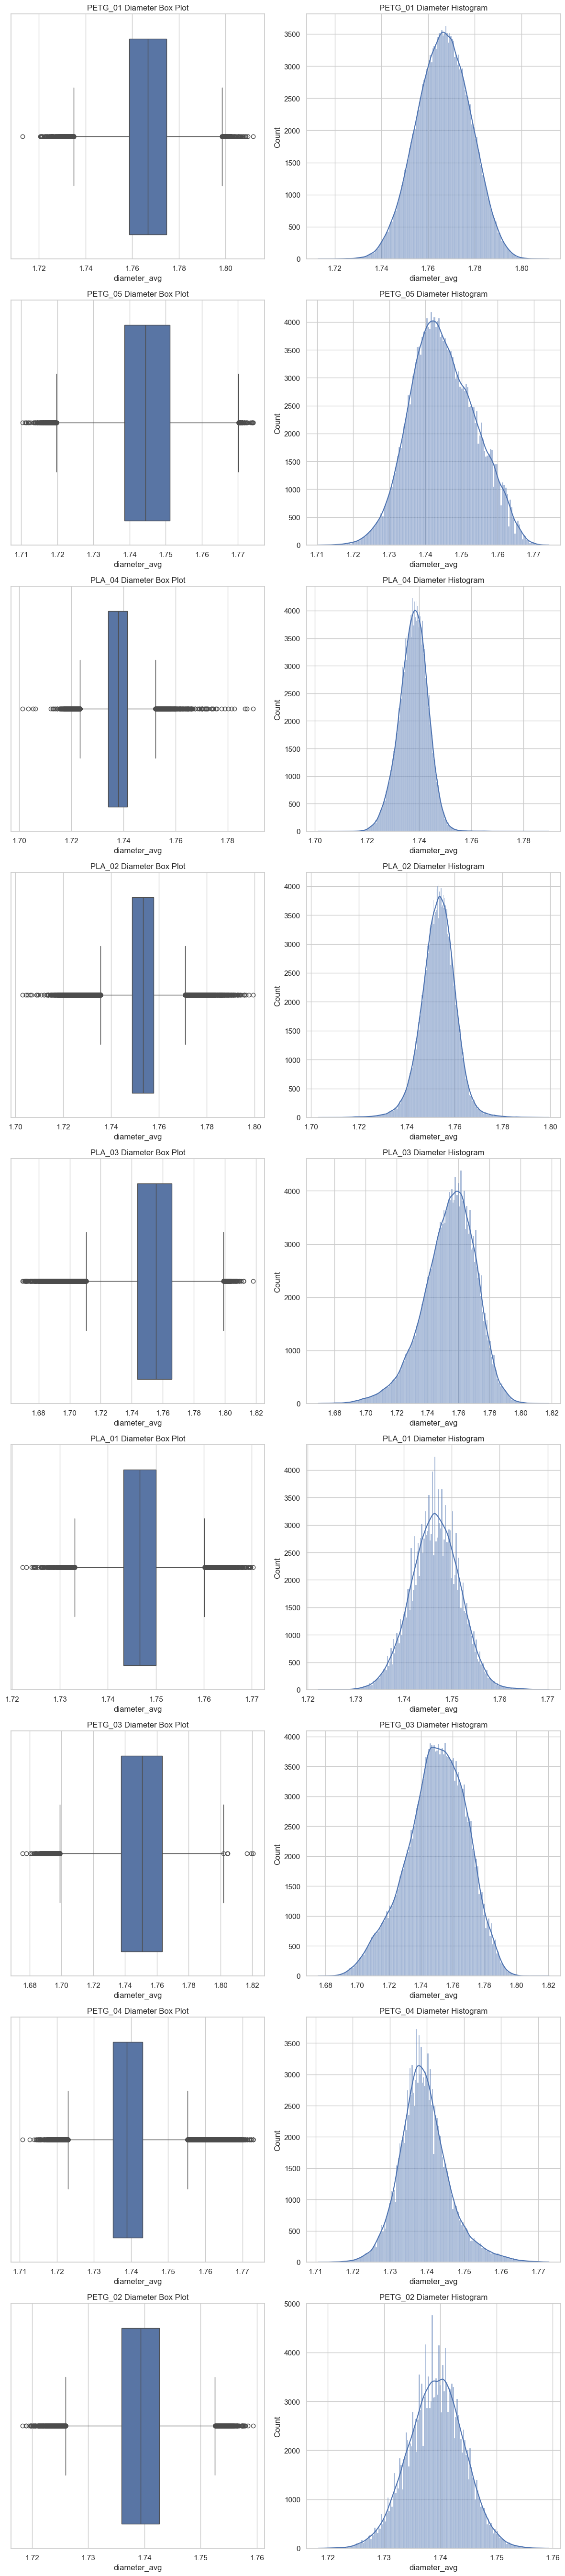

In [8]:
sns.set(style="whitegrid")

# Function to create plots for a given DataFrame
def create_plots(df, axs, row_index, name):
    if rolling_average_switch:
        # Use the rolling average DataFrame if the switch is on
        df = apply_rolling_average_and_downsample(df, down_sample_value, rolling_avg_resolution)

    sns.boxplot(x=df['diameter_avg'], ax=axs[row_index, 0]).set_title(f'{name} Diameter Box Plot')

    sns.histplot(df['diameter_avg'], kde=True, ax=axs[row_index, 1]).set_title(f'{name} Diameter Histogram')

num_plots = sum(len(v) for v in dataframes.values() if isinstance(v, dict)) if segment_switch else len(dataframes)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    fig, axs = plt.subplots(num_plots, 2, figsize=(12, 6 * num_plots))
    row_index = 0
    for name, item in dataframes.items():
        if segment_switch and isinstance(item, dict):
            for segment_name, df_segment in item.items():
                plot_title = f"{name} - {segment_name}"
                create_plots(df_segment, axs, row_index, plot_title)
                row_index += 1
        elif isinstance(item, pd.DataFrame):
            plot_title = f"{name}"
            create_plots(item, axs, row_index, plot_title)
            row_index += 1
        else:
            print(f"Unsupported data structure in dataframes[{name}]")
    plt.tight_layout()
    plt.show()


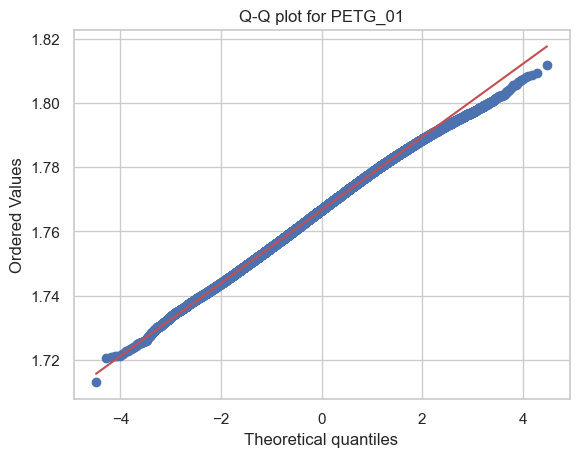

PETG_01 - Skewness: -0.07203562423342409, Kurtosis: -0.23154691316112208


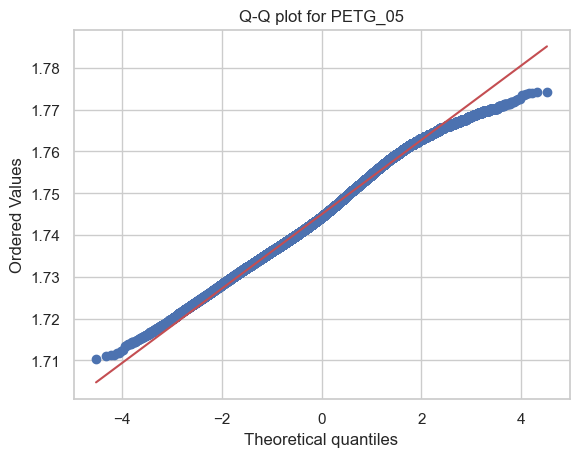

PETG_05 - Skewness: 0.12702811241210438, Kurtosis: -0.3330031648815064


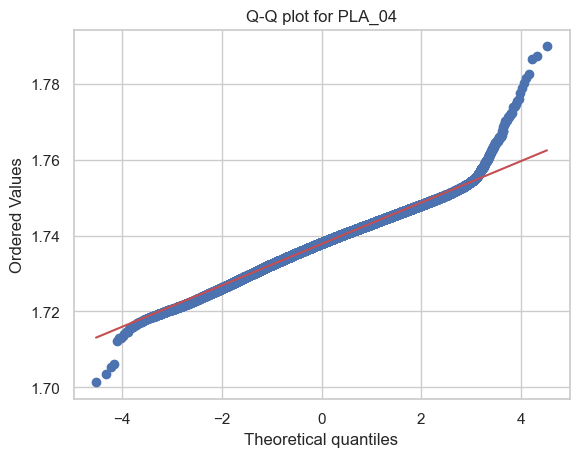

PLA_04 - Skewness: -0.1439309501624715, Kurtosis: 0.5412818445386205


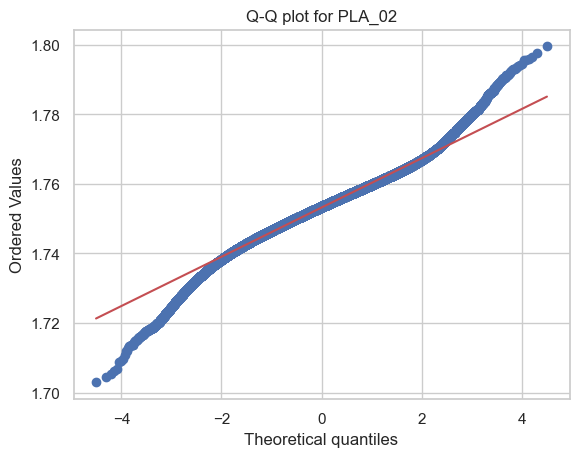

PLA_02 - Skewness: -0.16917241737061062, Kurtosis: 1.5073504992142963


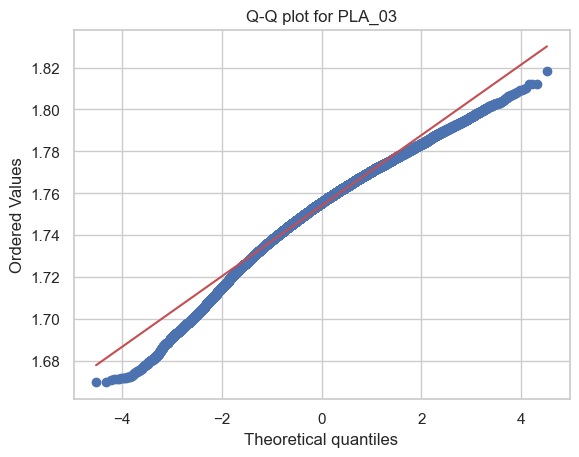

PLA_03 - Skewness: -0.5492307307181943, Kurtosis: 0.5899785470900776


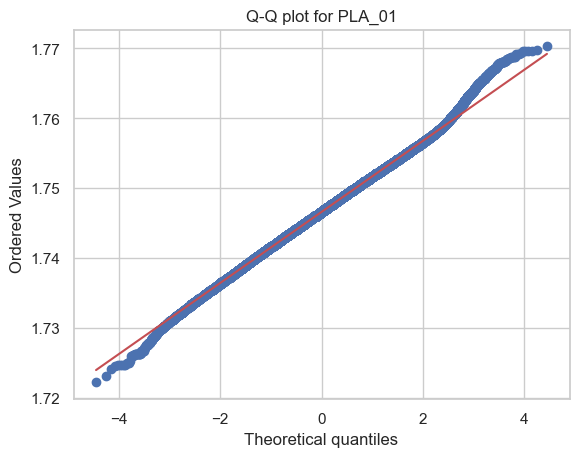

PLA_01 - Skewness: -0.0008206567109793132, Kurtosis: 0.2527816142105159


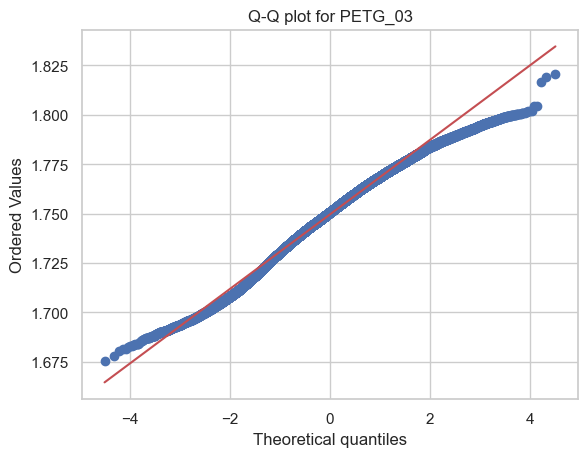

PETG_03 - Skewness: -0.3311158978636757, Kurtosis: -0.17261899403094372


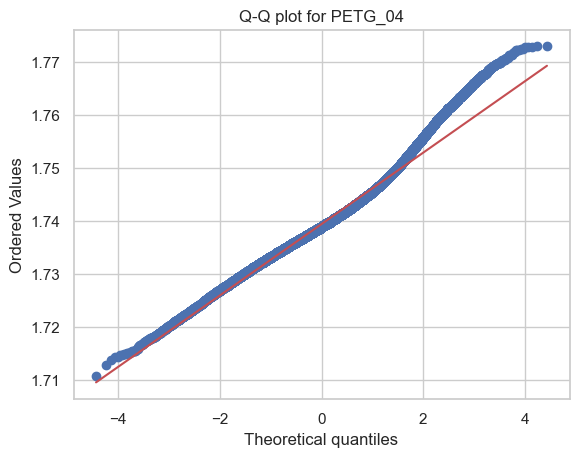

PETG_04 - Skewness: 0.5619393400630438, Kurtosis: 1.1356214196385372


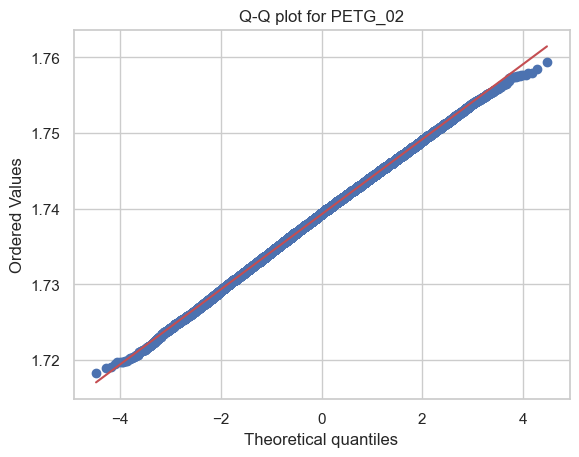

PETG_02 - Skewness: -0.07213840274323605, Kurtosis: -0.005844551319699409


In [9]:
def create_plots(df, axs, row_index, name):
    if rolling_average_switch:
        # Use the rolling average DataFrame if the switch is on
        df = apply_rolling_average_and_downsample(df, down_sample_value, rolling_avg_resolution)

    sns.boxplot(x=df['diameter_avg'], ax=axs[row_index, 0]).set_title(f'{name} Diameter Box Plot')
    sns.histplot(df['diameter_avg'], kde=True, ax=axs[row_index, 1]).set_title(f'{name} Diameter Histogram')
    
    # Add a Q-Q plot
    fig, ax = plt.subplots()
    stats.probplot(df['diameter_avg'].dropna(), dist="norm", plot=ax)
    ax.set_title(f'Q-Q plot for {name}')
    plt.show()

    # Calculate and display skewness and kurtosis
    skewness = df['diameter_avg'].skew()
    kurtosis = df['diameter_avg'].kurtosis()
    print(f"{name} - Skewness: {skewness}, Kurtosis: {kurtosis}")

    # Optional: You could still display Shapiro-Wilk results but take them with a grain of salt for large datasets
    if len(df['diameter_avg'].dropna()) < 5000:  # Limit to reasonable size for Shapiro-Wilk
        stat, p = shapiro(df['diameter_avg'].dropna())
        print(f"Normality test for {name}: Statistics={stat:.3f}, p-value={p:.3g}")
        if p > 0.05:
            print(f"The diameter data for {name} looks normally distributed (fail to reject H0)")
        else:
            print(f"The diameter data for {name} does not look normally distributed (reject H0)")

row_index = 0
for group_name, segments in dataframes.items():
    if isinstance(segments, dict):  # Checks if the value is a nested dictionary
        for segment_name, df in segments.items():
            plot_name = f"{group_name} - {segment_name}"  # Combines group and segment name for labeling
            create_plots(df, axs, row_index, plot_name)
            row_index += 1
    elif isinstance(segments, pd.DataFrame):  # Direct DataFrame
        create_plots(segments, axs, row_index, group_name)
        row_index += 1
    else:
        print(f"Unsupported data structure in dataframes[{group_name}]")

In [10]:
# Define the target diameter and the measurement increment
target_diameter = 1.75
measurement_increment = 1.49  # each measurement represents 1.49 mm

# Define weight and cost for each group
weights = {
    'PLA_01': 0.75,
    'PETG_01': 1.0,  
    'PETG_02': 1.0, 
    'PETG_03': 1.0, 
    'PETG_04': 1.0, 
    'PETG_05': 1.0,
    'PLA_02': 1.0, 
    'PLA_03': 1.0, 
    'PLA_04': 1.0 
}

cost_per_group = {
    'PETG_01': 45.60,  
    'PETG_02': 24.99, 
    'PETG_03': 45.60, 
    'PETG_04': 21.98, 
    'PETG_05': 24.99, 
    'PLA_01': 50, # Adjusted price for 0.75kg spool
    'PLA_02': 24.99, 
    'PLA_03': 20.87, 
    'PLA_04': 20.87 
}

def calculate_metrics(df, target, weight, cost, measurement_increment):
    cae = df['diameter_avg'].sub(target).abs().sum()
    meters_per_measurement = measurement_increment / 1000
    total_meters = len(df) * meters_per_measurement
    
    # Normalize total absolute error
    normalized_by_length = cae / total_meters if total_meters else cae
    normalized_by_weight = cae / weight if weight else cae
    normalized_by_cost = cae / cost if cost else cae

    return normalized_by_length, normalized_by_weight, normalized_by_cost

# Calculate and normalize CAE for each group or segment
cae_results = {}
if segment_switch:
    for (group, segment), group_df in combined_df.groupby(['group', 'segment']):
        weight = weights.get(group, 1)  # default to 1 kg if not specified
        cost = cost_per_group.get(group, 1)  # default to 1 dollar if not specified
        metrics = calculate_metrics(group_df, target_diameter, weight, cost, measurement_increment)
        cae_results[(group, segment)] = metrics
else:
    for group, group_df in combined_df.groupby('group'):
        weight = weights.get(group, 1)
        cost = cost_per_group.get(group, 1)
        metrics = calculate_metrics(group_df, target_diameter, weight, cost, measurement_increment)
        cae_results[group] = metrics

# Output the results
for key, (norm_length, norm_weight, norm_cost) in cae_results.items():
    print(f"{key} - Normalized by Length: {norm_length}, Normalized by Weight: {norm_weight}, "
          f"Normalized by Cost: {norm_cost}")


PETG_01 - Normalized by Length: 11.650943368511266, Normalized by Weight: 3286.7162110495165, Normalized by Cost: 72.07710989143676
PETG_02 - Normalized by Length: 7.255057864590831, Normalized by Weight: 2022.4496760705847, Normalized by Cost: 80.930359186498
PETG_03 - Normalized by Length: 10.187254316201601, Normalized by Weight: 3275.508695268646, Normalized by Cost: 71.83133103659311
PETG_04 - Normalized by Length: 7.557810448599276, Normalized by Weight: 1685.4769821394987, Normalized by Cost: 76.68230128023197
PETG_05 - Normalized by Length: 5.70125888747997, Normalized by Weight: 1812.8659475466525, Normalized by Cost: 72.54365536401171
PLA_01 - Normalized by Length: 3.294783974389154, Normalized by Weight: 1071.5535862477211, Normalized by Cost: 16.07330379371582
PLA_02 - Normalized by Length: 4.12437562533947, Normalized by Weight: 1303.2686715083635, Normalized by Cost: 52.151607503335875
PLA_03 - Normalized by Length: 9.413960267201102, Normalized by Weight: 3071.1399811488

In [12]:
def calculate_metrics(df, target, weight, cost, measurement_increment):
    cae = df['diameter_avg'].sub(target).abs().sum()
    meters_per_measurement = measurement_increment / 1000
    total_meters = len(df) * meters_per_measurement
    
    normalized_by_length = cae / total_meters if total_meters else cae
    normalized_by_weight = cae / weight if weight else cae
    normalized_by_cost = cae / cost if cost else cae

    return normalized_by_length, normalized_by_weight, normalized_by_cost

# Initialize the DataFrame and process data based on segment_switch
if segment_switch:
    output_directory = "segmented CAE"
    segment_order = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth']
else:
    output_directory = "Overall CAE"
    segment_order = ['overall']  # No segments, just an overall grouping

os.makedirs(output_directory, exist_ok=True)
all_results_df = pd.DataFrame()

if segment_switch:
    for (group, segment), group_df in combined_df.groupby(['group', 'segment']):
        weight = weights.get(group, 1)
        cost = cost_per_group.get(group, 1)
        norm_length, norm_weight, norm_cost = calculate_metrics(group_df, target_diameter, weight, cost, measurement_increment)
        new_row = pd.DataFrame({
            'Group': [group],
            'Segment': [segment],
            'Normalized by Length': [norm_length],
            'Normalized by Weight': [norm_weight],
            'Normalized by Cost': [norm_cost]
        })
        all_results_df = pd.concat([all_results_df, new_row], ignore_index=True)
else:
    for group, group_df in combined_df.groupby('group'):
        weight = weights.get(group, 1)
        cost = cost_per_group.get(group, 1)
        norm_length, norm_weight, norm_cost = calculate_metrics(group_df, target_diameter, weight, cost, measurement_increment)
        new_row = pd.DataFrame({
            'Group': [group],
            'Segment': ['overall'],
            'Normalized by Length': [norm_length],
            'Normalized by Weight': [norm_weight],
            'Normalized by Cost': [norm_cost]
        })
        all_results_df = pd.concat([all_results_df, new_row], ignore_index=True)

# Set 'Segment' as a categorical type with a defined order and sort the DataFrame
all_results_df['Segment'] = pd.Categorical(all_results_df['Segment'], categories=segment_order, ordered=True)
all_results_df.sort_values(by=['Group', 'Segment'], inplace=True)

# Save results to CSV files in the specified directory
for group in all_results_df['Group'].unique():
    group_df = all_results_df[all_results_df['Group'] == group]
    filename = os.path.join(output_directory, f"{group}_deviations.csv")
    group_df.to_csv(filename, index=False)
    print(f"Saved results for {group} to {filename}")

all_in_one_filename = os.path.join(output_directory, "All_Deviations.csv")
all_results_df.to_csv(all_in_one_filename, index=False)
print(f"Saved comprehensive results to {all_in_one_filename}")

Saved results for PETG_01 to Overall CAE\PETG_01_deviations.csv
Saved results for PETG_02 to Overall CAE\PETG_02_deviations.csv
Saved results for PETG_03 to Overall CAE\PETG_03_deviations.csv
Saved results for PETG_04 to Overall CAE\PETG_04_deviations.csv
Saved results for PETG_05 to Overall CAE\PETG_05_deviations.csv
Saved results for PLA_01 to Overall CAE\PLA_01_deviations.csv
Saved results for PLA_02 to Overall CAE\PLA_02_deviations.csv
Saved results for PLA_03 to Overall CAE\PLA_03_deviations.csv
Saved results for PLA_04 to Overall CAE\PLA_04_deviations.csv
Saved comprehensive results to Overall CAE\All_Deviations.csv


# Kruskal-Wallis Tests

## Evaluating difference in medians across groups against baseline, within sections of groups against each other, andwithin sections of groups against baseline

### Baseline = 1.75 mm
### Practical significance is set at a 0.01 mm difference, but can be changed

In [ ]:
# Define the practical significance threshold
practical_threshold = 0.01

def epsilon_squared(H, n_total):
    return H * (n_total - 1) / (n_total ** 2 - 1)

def median_confidence_interval(data, confidence=0.99):
    data = np.array(data)
    n = len(data)
    m = np.median(data)
    se = 1.253 * (np.std(data, ddof=1) / np.sqrt(n))
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

hypothesized_median = 1.75  # Set the hypothesized median diameter

# Prepare the data for each group
group_data = {}
for group_name, segments in dataframes.items():
    all_diameters = []
    for section_name, df in segments.items():
        if 'diameter_avg' in df.columns:
            data = df['diameter_avg'].dropna().tolist()
            if data:
                all_diameters.extend(data)
    if all_diameters:
        group_data[group_name] = all_diameters

# Perform Wilcoxon signed-rank test for each group against the hypothesized median
results = {}
for group_name, data in group_data.items():
    if len(data) > 1:
        stat, p = stats.wilcoxon(np.array(data) - hypothesized_median)
        results[group_name] = p

# Print results and check against a significance level
print("Wilcoxon Signed-Rank Test Results:")
for group_name, p_value in results.items():
    median, lower, upper = median_confidence_interval(group_data[group_name])
    diff_direction = median - hypothesized_median
    diff = abs(median - hypothesized_median)
    print(f"{group_name} - p-value: {p_value:.5f}")
    print(f"Median: {median}, 99% CI: ({lower}, {upper})")
    print(f"Difference from hypothesized median: {diff_direction:.5f}")
    if diff > practical_threshold:
        print(f"Practically significant difference from the hypothesized median for {group_name}.")
    else:
        print(f"No practically significant difference from the hypothesized median for {group_name}.")
    print("\n")

# Perform Kruskal-Wallis test across all groups
test_data = [data for data in group_data.values()]
if len(test_data) > 1:
    stat, p = stats.kruskal(*test_data)
    n_total = sum(len(data) for data in test_data)
    eps_sq = epsilon_squared(stat, n_total)

    print("Kruskal-Wallis Test across all groups:")
    print(f"Statistic: {stat}, p-value: {p}, epsilon squared: {eps_sq}\n")

    # Calculate medians and confidence intervals for each group
    median_cis = {}
    for group_name, values in group_data.items():
        median, lower, upper = median_confidence_interval(values)
        median_cis[group_name] = (median, lower, upper)
        print(f"{group_name} - Median: {median}, 99% CI: ({lower}, {upper})")

    print("\n")

    # Perform pairwise comparisons with Bonferroni correction
    comparisons = []
    p_values = []
    for group1, group2 in itertools.combinations(group_data.keys(), 2):
        data1 = group_data[group1]
        data2 = group_data[group2]
        stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        comparisons.append((group1, group2))
        p_values.append(p)

    reject, p_adjusted, _, _ = multipletests(p_values, method='bonferroni')
    print("Pairwise Comparisons with Bonferroni Correction:")
    for (group1, group2), p, p_adj, rej in zip(comparisons, p_values, p_adjusted, reject):
        median1, _, _ = median_cis[group1]
        median2, _, _ = median_cis[group2]
        diff = abs(median1 - median2)
        print(f"{group1} vs {group2}: p-value: {p:.5f}, adjusted p-value: {p_adj:.5f}, reject: {rej}")
        if diff >= practical_threshold:
            print(f"The difference between {group1} and {group2} is practically significant.")
        else:
            print(f"No practically significant difference between {group1} and {group2}.")

        print("\n")
else:
    print("Not enough data to perform Kruskal-Wallis test.")


In [ ]:
# Prepare the data for each group and section
group_section_data = {}
for group_name, segments in dataframes.items():
    for section_name, df in segments.items():
        if 'diameter_avg' in df.columns:
            data = df['diameter_avg'].dropna().tolist()
            if data:
                key = (group_name, section_name)
                group_section_data[key] = data

# Perform Wilcoxon signed-rank test for each group-section against the hypothesized median
results = {}
for key, data in group_section_data.items():
    if len(data) > 1:
        stat, p = stats.wilcoxon(np.array(data) - hypothesized_median)
        results[key] = p

# Print results and check against a significance level
print("Wilcoxon Signed-Rank Test Results:")
for key, p_value in results.items():
    group_name, section_name = key
    median, lower, upper = median_confidence_interval(group_section_data[key])
    diff_direction = median - hypothesized_median
    diff = abs(median - hypothesized_median)
    print(f"{group_name} - {section_name} - p-value: {p_value:.5f}")
    print(f"Median: {median}, 99% CI: ({lower}, {upper})")
    print(f"Difference from hypothesized median: {diff_direction:.5f}")
    if diff > practical_threshold:
        print(f"Practically significant difference from the hypothesized median for {group_name} - {section_name}.")
    else:
        print(f"No practically significant difference from the hypothesized median for {group_name} - {section_name}.")
    print("\n")

# Prepare data for Kruskal-Wallis test across all groups
test_data = [data for data in group_section_data.values()]
if len(test_data) > 1:
    stat, p = stats.kruskal(*test_data)
    n_total = sum(len(data) for data in test_data)
    eps_sq = epsilon_squared(stat, n_total)

    print("Kruskal-Wallis Test across all sections:")
    print(f"Statistic: {stat}, p-value: {p}, epsilon squared: {eps_sq}\n")

    # Calculate medians and confidence intervals for each group-section
    median_cis = {}
    for key, values in group_section_data.items():
        median, lower, upper = median_confidence_interval(values)
        median_cis[key] = (median, lower, upper)
        print(f"{key[0]} - {key[1]} - Median: {median}, 99% CI: ({lower}, {upper})")

    # Perform pairwise comparisons with Bonferroni correction
    comparisons = []
    p_values = []
    for key1, key2 in itertools.combinations(group_section_data.keys(), 2):
        data1 = group_section_data[key1]
        data2 = group_section_data[key2]
        stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
        comparisons.append((key1, key2))
        p_values.append(p)

    reject, p_adjusted, _, _ = multipletests(p_values, method='bonferroni')
    print("\nPairwise Comparisons with Bonferroni Correction:")
    for (key1, key2), p, p_adj, rej in zip(comparisons, p_values, p_adjusted, reject):
        median1, _, _ = median_cis[key1]
        median2, _, _ = median_cis[key2]
        diff = abs(median1 - median2)
        print(f"{key1[0]} - {key1[1]} vs {key2[0]} - {key2[1]}: p-value: {p:.5f}, adjusted p-value: {p_adj:.5f}, reject: {rej}")
        if diff >= practical_threshold:
            print(f"Practically significant difference between {key1[0]} - {key1[1]} and {key2[0]} - {key2[1]}.")
        else:
            print(f"No practically significant difference between {key1[0]} - {key1[1]} and {key2[0]} - {key2[1]}.")

else:
    print("Not enough data to perform Kruskal-Wallis test.")


# Mixed Effects Model

In [ ]:
data_for_modeling = []

# Loop through each group and its sections
for group_name, segments in dataframes.items():
    if isinstance(segments, dict):  # Ensuring that the group contains nested DataFrames
        for section_name, df in segments.items():
            # Check if 'diameter_avg' is a column in the DataFrame
            if 'diameter_avg' in df.columns:
                # Create a temporary DataFrame to hold the data for this section
                temp_df = df[['diameter_avg']].dropna()  # Drop NA values in 'diameter_avg'
                temp_df['group'] = group_name  # Add a column for the group
                temp_df['section'] = section_name  # Add a column for the section
                data_for_modeling.append(temp_df)  # Append to the list

# Concatenate all the temporary DataFrames into a single DataFrame
final_data_for_model = pd.concat(data_for_modeling, ignore_index=True)

# Center the 'diameter_avg' around 1.75 mm
final_data_for_model['centered_diameter'] = final_data_for_model['diameter_avg'] - 1.75

# Fit a mixed effects model using the centered diameter as the dependent variable
model = smf.mixedlm("centered_diameter ~ group + section + group:section-1", data=final_data_for_model, groups=final_data_for_model["group"])
result = model.fit()
print(result.summary())

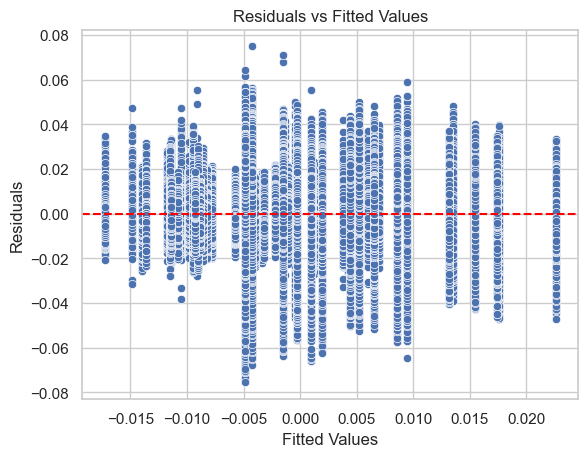

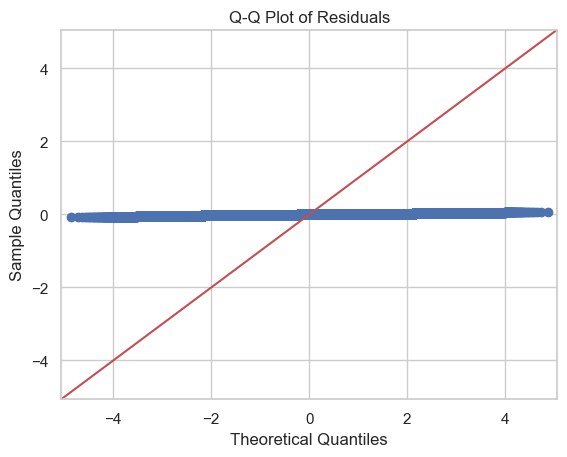

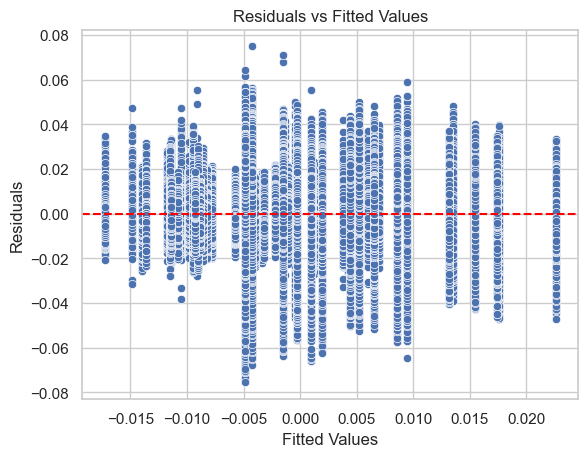

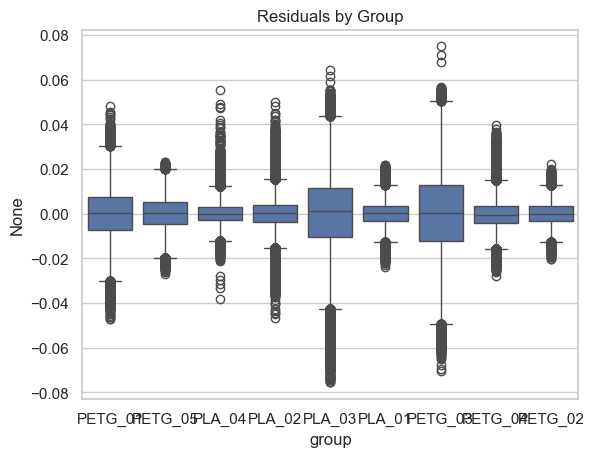

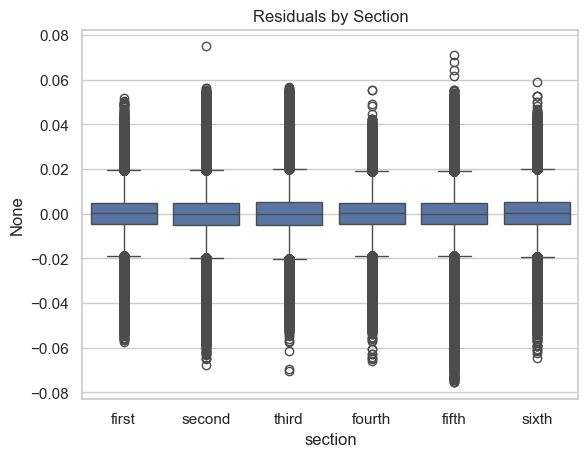

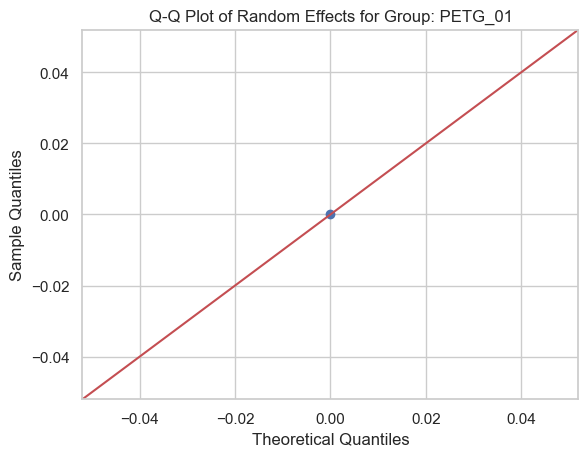

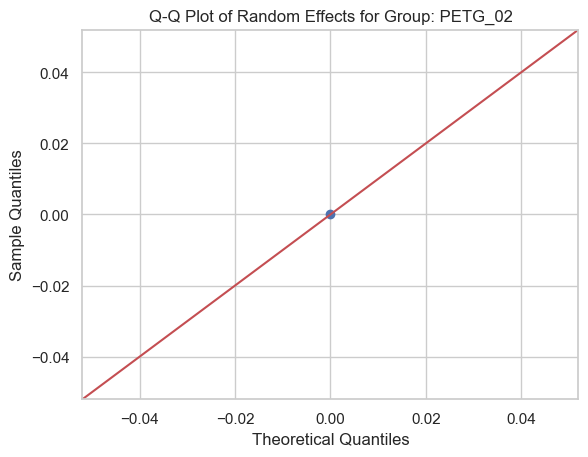

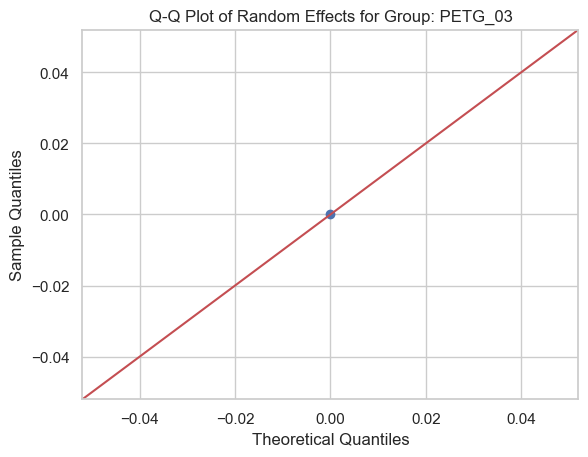

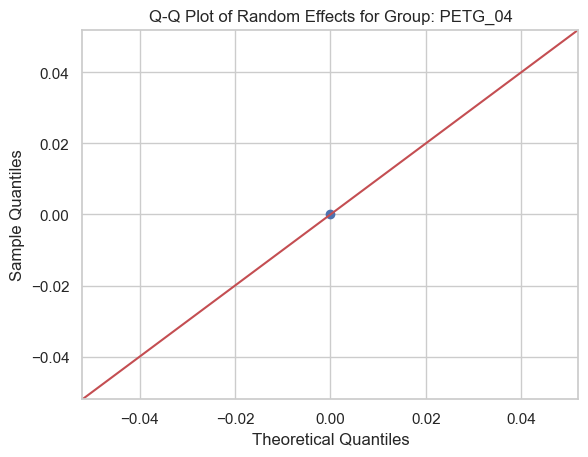

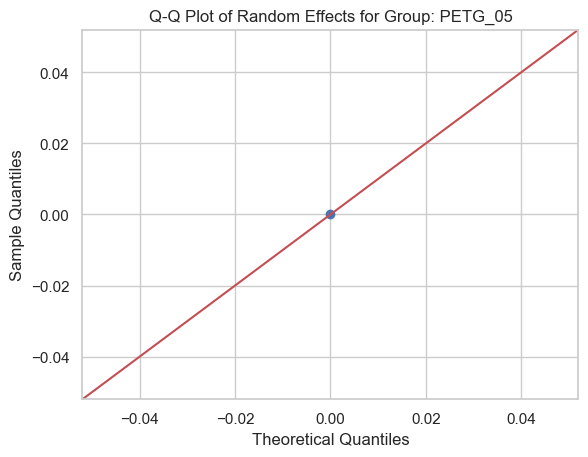

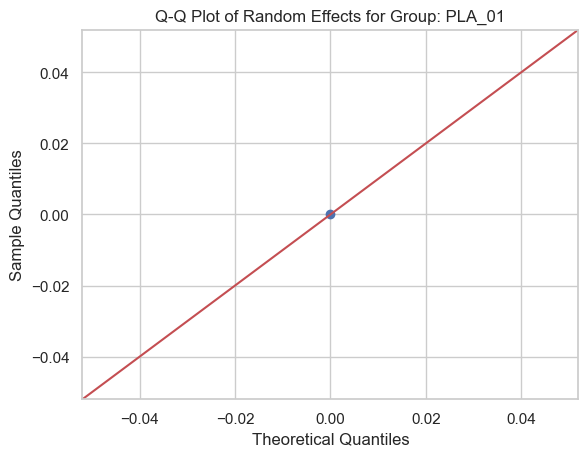

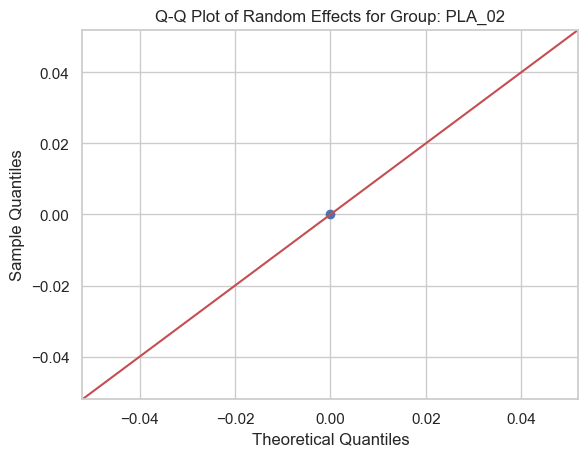

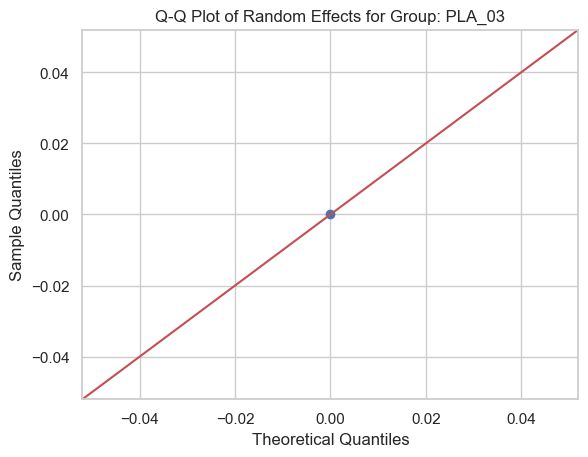

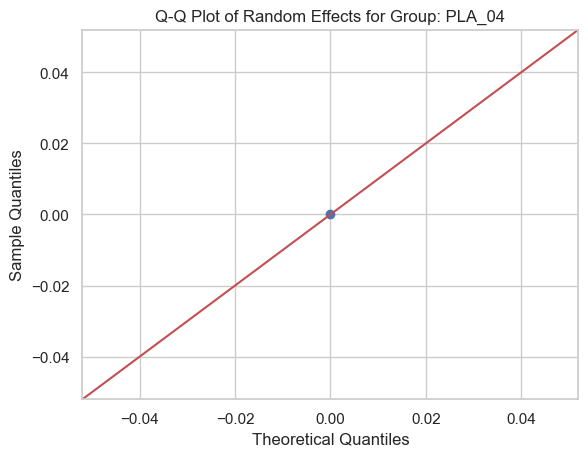

Shapiro-Wilk Test for Normality of Residuals: Statistic=0.946607232093811, p-value=0.0


In [26]:
# Extract residuals
residuals = result.resid
fitted_values = result.fittedvalues

# Linearity
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Normality of residuals
sm.qqplot(residuals, line='45')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Homoscedasticity
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

# Plot residuals for each group
sns.boxplot(x=final_data_for_model['group'], y=residuals)
plt.title('Residuals by Group')
plt.show()

# Plot residuals for each section
sns.boxplot(x=final_data_for_model['section'], y=residuals)
plt.title('Residuals by Section')
plt.show()

# Random Effects Normality
random_effects = result.random_effects
for group, re in random_effects.items():
    sm.qqplot(re, line='45')
    plt.title(f'Q-Q Plot of Random Effects for Group: {group}')
    plt.show()

# Statistical test for normality of residuals
stat, p_value = stats.shapiro(residuals)
print(f'Shapiro-Wilk Test for Normality of Residuals: Statistic={stat}, p-value={p_value}')

Mean Squared Error on test data: 0.0001092225114143098
R-squared on test data: 0.4404709068325414


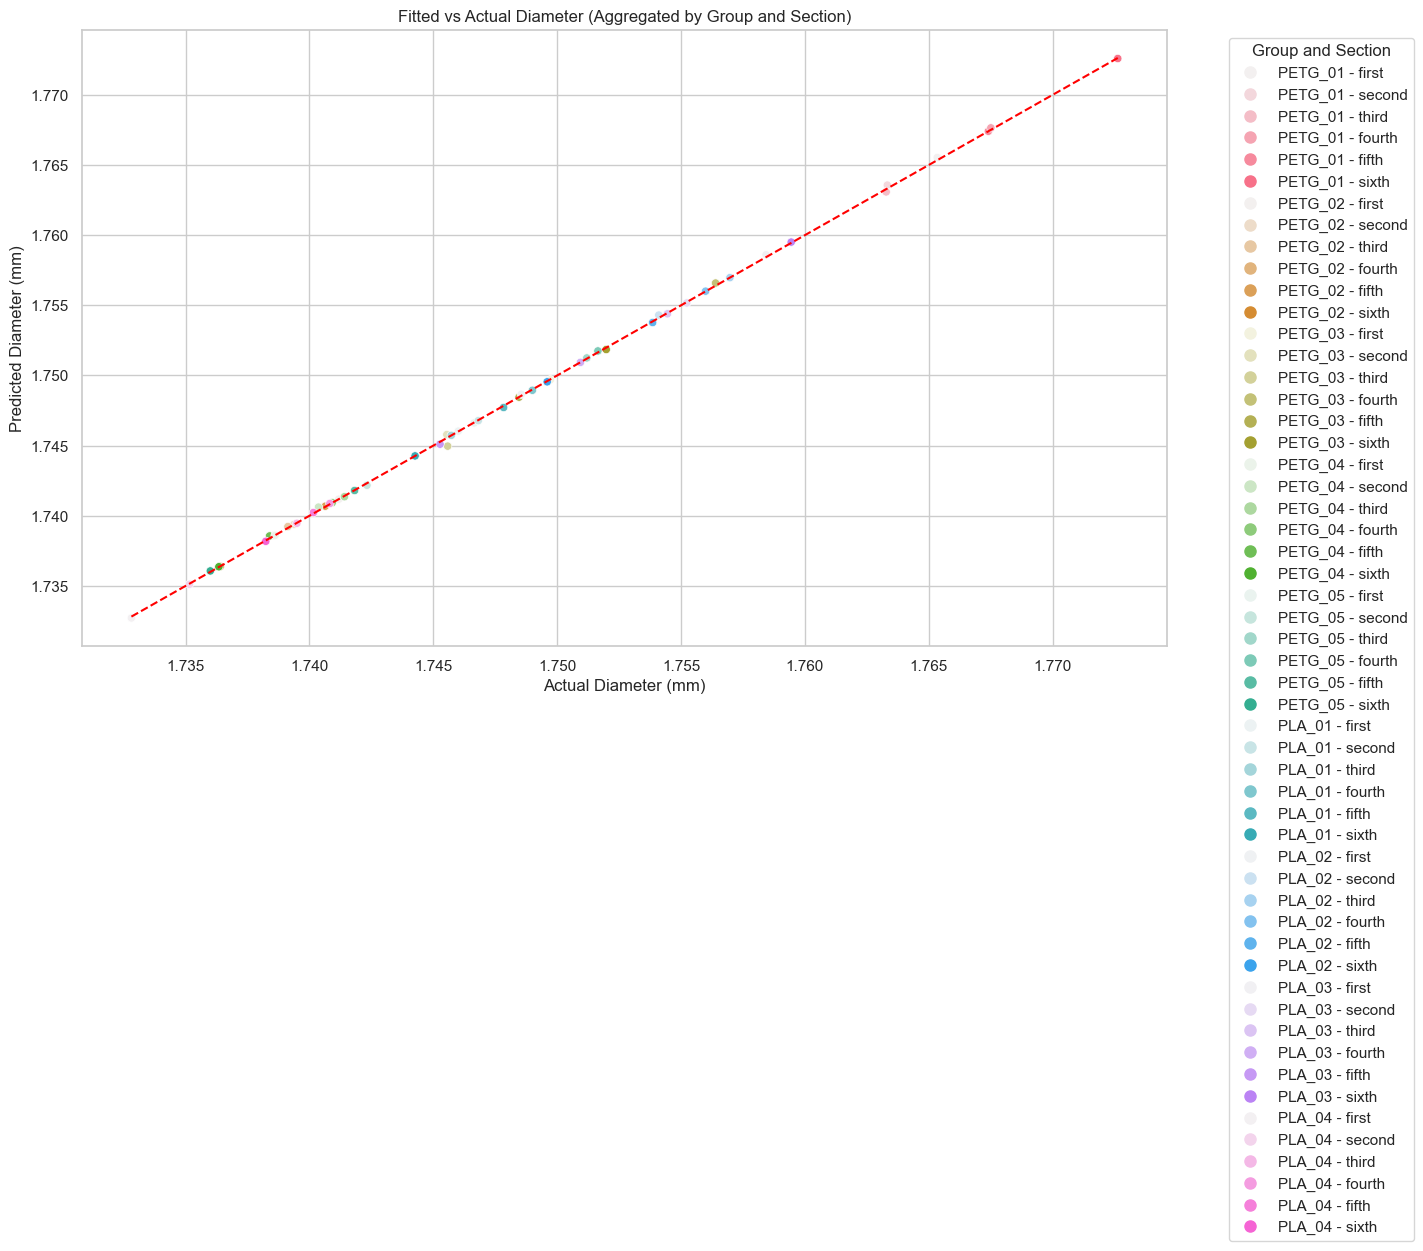

In [27]:
# Train-test split
train_data, test_data = train_test_split(final_data_for_model, test_size=0.3, random_state=14)

# Fit the mixed effects model on the training data
train_model = smf.mixedlm("centered_diameter ~ group + section + group:section - 1", data=train_data, groups=train_data["group"])
train_result = train_model.fit()

# Predict on the testing data
test_data['predicted'] = train_result.predict(test_data) + 1.75  # Adding back the centered value

# Calculate performance metrics
mse = mean_squared_error(test_data['diameter_avg'], test_data['predicted'])
r2 = r2_score(test_data['diameter_avg'], test_data['predicted'])

print(f"Mean Squared Error on test data: {mse}")
print(f"R-squared on test data: {r2}")

# Aggregate data for plotting by group and section
aggregated_test_data = test_data.groupby(['group', 'section']).agg(
    actual_diameter=('diameter_avg', 'mean'),
    predicted_diameter=('predicted', 'mean')
).reset_index()

# Map section to color intensity
section_order = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth']
section_mapping = {section: i for i, section in enumerate(section_order)}
aggregated_test_data['color_intensity'] = aggregated_test_data['section'].map(section_mapping)

# Assign unique colors to each group dynamically
unique_groups = aggregated_test_data['group'].unique()
color_palette = sns.color_palette("husl", len(unique_groups))  # Use the husl color palette for distinct colors
group_colors = {group: color for group, color in zip(unique_groups, color_palette)}

# Plot actual vs predicted aggregated data with color intensity increasing by section
plt.figure(figsize=(14, 8))

for group_name, group_data in aggregated_test_data.groupby('group'):
    base_color = group_colors[group_name]
    palette = sns.light_palette(base_color, n_colors=len(section_order), reverse=False)
    sns.scatterplot(x='actual_diameter', y='predicted_diameter', data=group_data, label=group_name,
                    hue='color_intensity', palette=palette, legend=False)

plt.plot([aggregated_test_data['actual_diameter'].min(), aggregated_test_data['actual_diameter'].max()],
         [aggregated_test_data['actual_diameter'].min(), aggregated_test_data['actual_diameter'].max()],
         color='red', linestyle='--')

plt.title('Fitted vs Actual Diameter (Aggregated by Group and Section)')
plt.xlabel('Actual Diameter (mm)')
plt.ylabel('Predicted Diameter (mm)')
plt.grid(True)

# Create a custom legend
handles = []
for group_name, base_color in group_colors.items():
    palette = sns.light_palette(base_color, n_colors=len(section_order), reverse=False)
    for intensity, section in enumerate(section_order):
        handles.append(plt.Line2D([0], [0], marker='o', color=palette[intensity], label=f'{group_name} - {section}',
                                  markersize=8, linestyle=''))

plt.legend(handles=handles, title='Group and Section', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


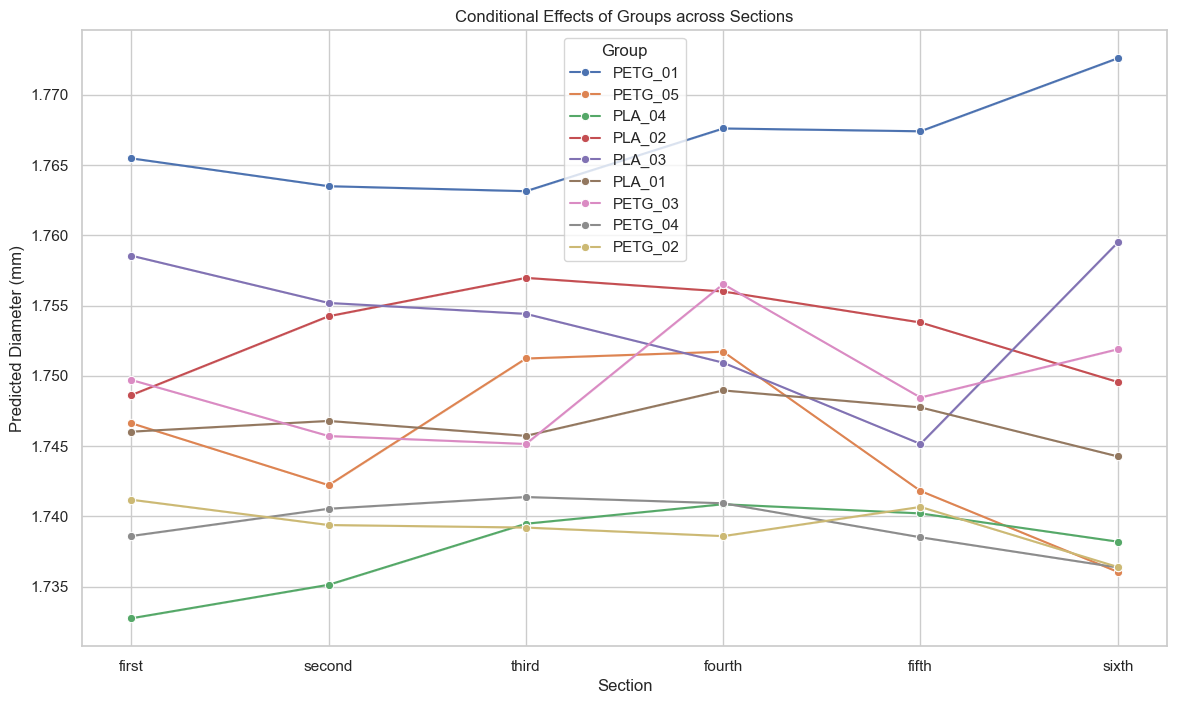

In [28]:
final_data_for_model['predicted'] = result.fittedvalues + 1.75

# Plot conditional effects
plt.figure(figsize=(14, 8))
sns.lineplot(x='section', y='predicted', hue='group', data=final_data_for_model, marker='o')
plt.title('Conditional Effects of Groups across Sections')
plt.xlabel('Section')
plt.ylabel('Predicted Diameter (mm)')
plt.legend(title='Group')
plt.grid(True)
plt.show()

             Mixed Linear Model Regression Results
Model:            MixedLM  Dependent Variable: centered_diameter
No. Observations: 1775102  Method:             REML             
No. Groups:       9        Scale:              0.0001           
Min. group size:  149459   Log-Likelihood:     5493730.5473     
Max. group size:  225426   Converged:          Yes              
Mean group size:  197233.6                                      
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
group[PETG_01]        0.016    0.011   1.410 0.158 -0.006  0.037
group[PETG_02]       -0.012    0.011  -1.060 0.289 -0.033  0.010
group[PETG_03]       -0.001    0.011  -0.126 0.900 -0.023  0.020
group[PETG_04]       -0.012    0.011  -1.054 0.292 -0.033  0.010
group[PETG_05]       -0.006    0.011  -0.546 0.585 -0.028  0.016
group[PLA_01]        -0.004    0.011  -

<Figure size 800x600 with 0 Axes>

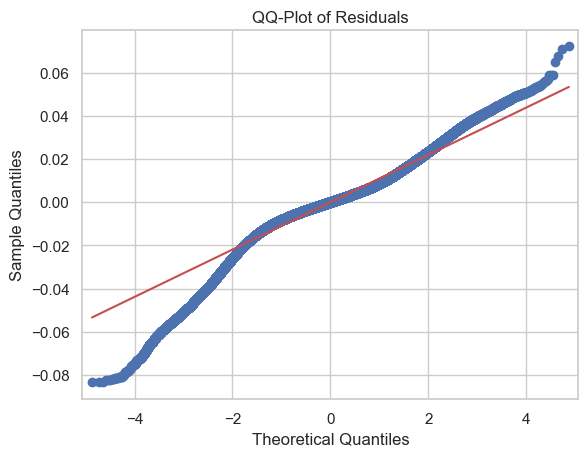

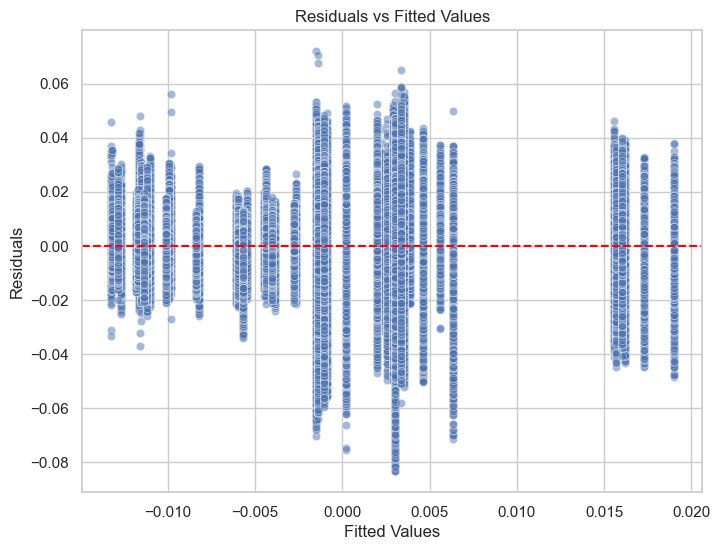

In [29]:
# Simplify the model by removing interactions, non-significant predictors, and the intercept
simplified_model = smf.mixedlm("centered_diameter ~ group + section - 1", data=final_data_for_model, groups=final_data_for_model["group"])
simplified_result = simplified_model.fit()
print(simplified_result.summary())

# Evaluate model assumptions
residuals = final_data_for_model['centered_diameter'] - simplified_result.fittedvalues

# QQ plot of residuals
plt.figure(figsize=(8, 6))
sm.qqplot(residuals, line='s')
plt.title('QQ-Plot of Residuals')
plt.show()

# Residuals vs. Fitted Values
fitted = simplified_result.fittedvalues
plt.figure(figsize=(8, 6))
sns.scatterplot(x=fitted, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()


Mean Squared Error on test data: 0.00011997831271096904
R-squared on test data: 0.385370692894221


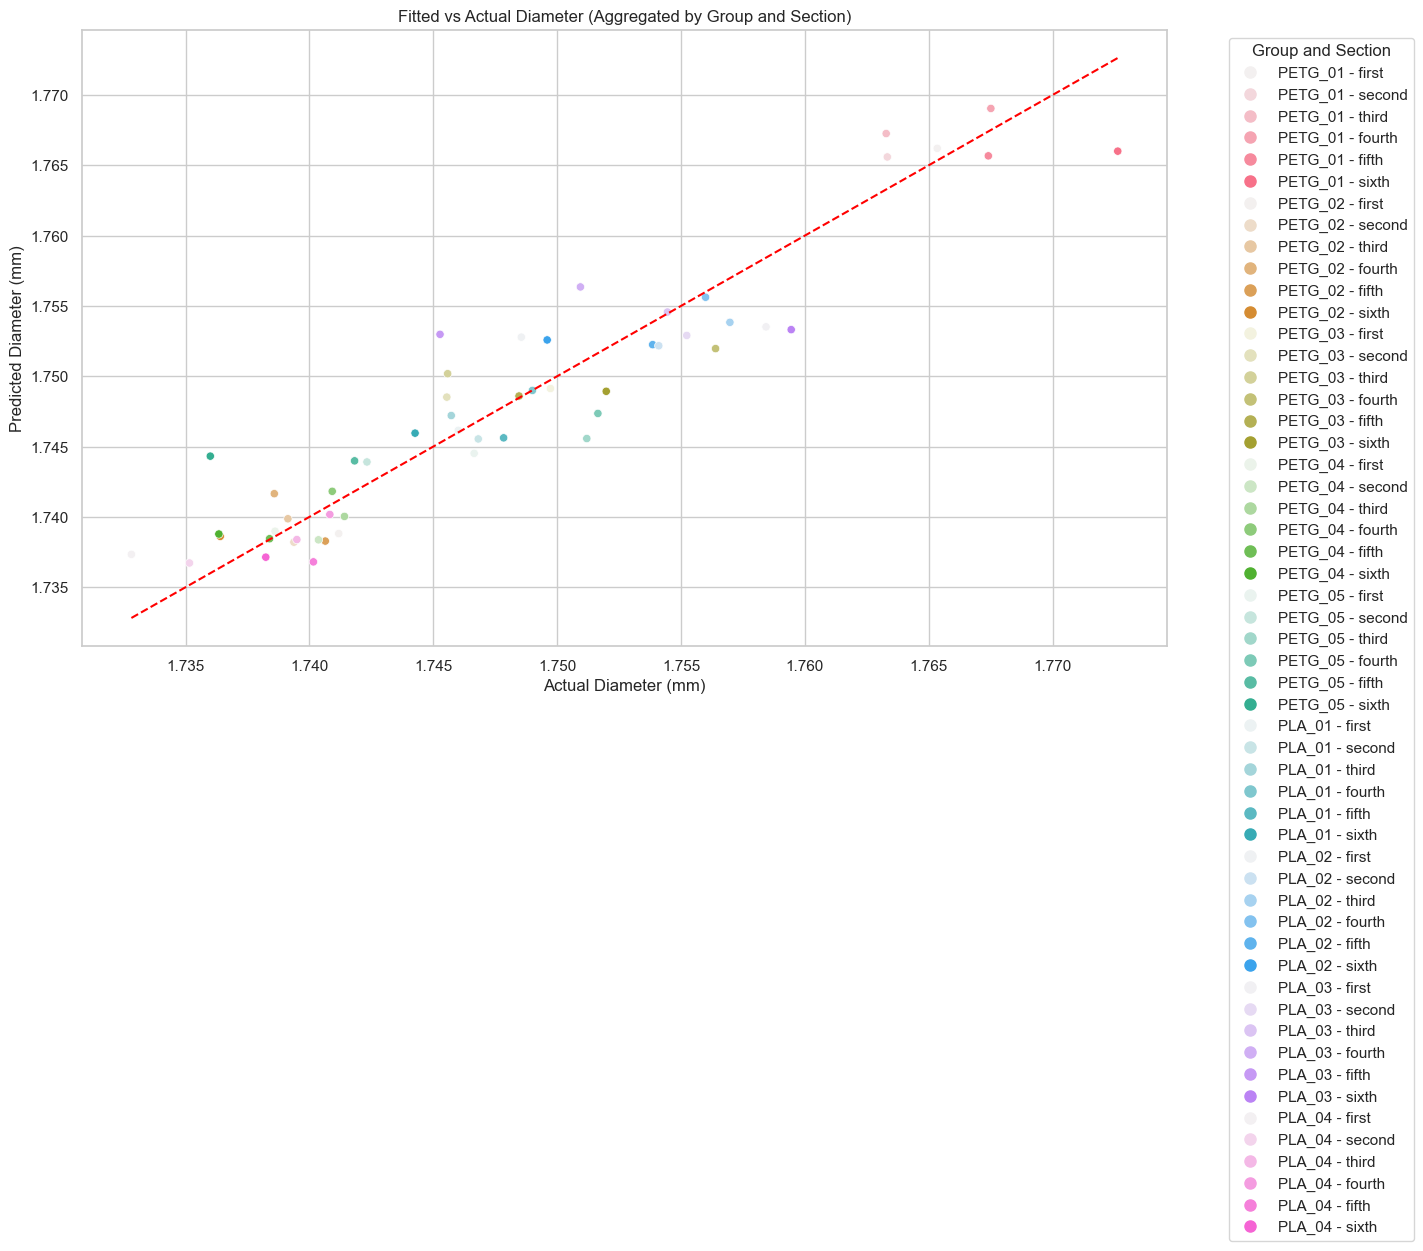

In [30]:
# Train-test split
train_data, test_data = train_test_split(final_data_for_model, test_size=0.3, random_state=14)

# Fit the mixed effects model on the training data
train_model = smf.mixedlm("centered_diameter ~ group + section - 1", data=train_data, groups=train_data["group"])
train_result = train_model.fit()

# Predict on the testing data
test_data['predicted'] = train_result.predict(test_data) + 1.75  # Adding back the centered value

# Calculate performance metrics
mse = mean_squared_error(test_data['diameter_avg'], test_data['predicted'])
r2 = r2_score(test_data['diameter_avg'], test_data['predicted'])

print(f"Mean Squared Error on test data: {mse}")
print(f"R-squared on test data: {r2}")

# Aggregate data for plotting by group and section
aggregated_test_data = test_data.groupby(['group', 'section']).agg(
    actual_diameter=('diameter_avg', 'mean'),
    predicted_diameter=('predicted', 'mean')
).reset_index()

# Map section to color intensity
section_order = ['first', 'second', 'third', 'fourth', 'fifth', 'sixth']
section_mapping = {section: i for i, section in enumerate(section_order)}
aggregated_test_data['color_intensity'] = aggregated_test_data['section'].map(section_mapping)

# Assign unique colors to each group dynamically
unique_groups = aggregated_test_data['group'].unique()
color_palette = sns.color_palette("husl", len(unique_groups))  # Use the husl color palette for distinct colors
group_colors = {group: color for group, color in zip(unique_groups, color_palette)}

# Plot actual vs predicted aggregated data with color intensity increasing by section
plt.figure(figsize=(14, 8))

for group_name, group_data in aggregated_test_data.groupby('group'):
    base_color = group_colors[group_name]
    palette = sns.light_palette(base_color, n_colors=len(section_order), reverse=False)
    sns.scatterplot(x='actual_diameter', y='predicted_diameter', data=group_data, label=group_name,
                    hue='color_intensity', palette=palette, legend=False)

plt.plot([aggregated_test_data['actual_diameter'].min(), aggregated_test_data['actual_diameter'].max()],
         [aggregated_test_data['actual_diameter'].min(), aggregated_test_data['actual_diameter'].max()],
         color='red', linestyle='--')

plt.title('Fitted vs Actual Diameter (Aggregated by Group and Section)')
plt.xlabel('Actual Diameter (mm)')
plt.ylabel('Predicted Diameter (mm)')
plt.grid(True)

# Create a custom legend
handles = []
for group_name, base_color in group_colors.items():
    palette = sns.light_palette(base_color, n_colors=len(section_order), reverse=False)
    for intensity, section in enumerate(section_order):
        handles.append(plt.Line2D([0], [0], marker='o', color=palette[intensity], label=f'{group_name} - {section}',
                                  markersize=8, linestyle=''))

plt.legend(handles=handles, title='Group and Section', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
